In [30]:
%%capture --no-stderr
# Suppress output and errors while installing required packages
%pip install --quiet -U langgraph langchain

In [31]:
# Import the TypedDict class for defining custom types
from typing_extensions import TypedDict

# Define a custom type to represent the state structure
class LearningState(TypedDict):
    prompt: str  # Represents the input prompt for the state


In [33]:
# Create an example instance of LearningState
lahore_state: LearningState = LearningState(prompt="Hello from UMT Lahore")

In [34]:
lahore_state

{'prompt': 'Hello from UMT Lahore'}

In [35]:
# Display the current state and its properties
print(lahore_state)  # Print the entire state dictionary
print(lahore_state["prompt"])  # Print the prompt value
print(lahore_state["prompt"] + " I am")  # Concatenate additional text to the prompt

{'prompt': 'Hello from UMT Lahore'}
Hello from UMT Lahore
Hello from UMT Lahore I am


#Node

In [36]:
# Define a function for Node 1
# This node appends " I am " to the current state's prompt
def node_1(state: LearningState) -> LearningState:
    print("---Node 1 State---", state)  # Log the current state
    return {"prompt": state["prompt"] + " I am "}  # Modify the state and return it

# Define a function for Node 2
# This node appends " Happy!" to the current state's prompt
def node_2(state: LearningState) -> LearningState:
    print("---Node 2 State---", state)  # Log the current state
    return {"prompt": state["prompt"] + " Happy!"}  # Modify the state and return it

#Edge

In [37]:
# Import tools for visualizing the graph
from IPython.display import Image, display

# Import LangGraph classes to build and manage state graphs
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph


In [38]:
# Initialize a StateGraph builder with the defined state schema
builder: StateGraph = StateGraph(state_schema=LearningState)
print(type(builder))  # Confirm the type of the builder


<class 'langgraph.graph.state.StateGraph'>


In [39]:
# Add the defined nodes to the graph
builder.add_node("node_1", node_1)  # Add Node 1 to the graph
builder.add_node("node_2", node_2)  # Add Node 2 to the graph

In [40]:
# Define the connections (edges) between the nodes
builder.add_edge(START, "node_1")  # Connect START to Node 1
builder.add_edge("node_1", "node_2")  # Connect Node 1 to Node 2
builder.add_edge("node_2", END)  # Connect Node 2 to END

In [41]:
# Compile the graph into an executable structure
graph: CompiledStateGraph = builder.compile()
print(graph)  # Display the compiled graph details


Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=<class 'langchain_core.utils.pydantic.LangGraphInput'>, metadata=None), 'node_1': Node(id='node_1', name='node_1', data=node_1(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None), 'node_2': Node(id='node_2', name='node_2', data=node_2(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=<class 'langchain_core.utils.pydantic.LangGraphOutput'>, metadata=None)}, edges=[Edge(source='__start__', target='node_1', data=None, conditional=False), Edge(source='node_1', target='node_2', data=None, conditional=False), Edge(source='node_2', target='__end__', data=None, conditional=False)])


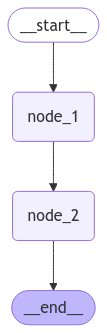

In [42]:
# Visualize the graph using Mermaid and display it as an image
print(graph.get_graph())  # Print the graph structure
display(Image(graph.get_graph().draw_mermaid_png()))  # Render and display the graph


#Graph Invocation

In [43]:
# Test the graph with an initial state
graph.invoke({"prompt": "My Name is Junaid"})  # Run the graph with a sample input state

---Node 1 State--- {'prompt': 'My Name is Junaid'}
---Node 2 State--- {'prompt': 'My Name is Junaid I am '}


{'prompt': 'My Name is Junaid I am  Happy!'}

#Task: In Nodes Use LLM == GoogleChatModel in Langchain

In [44]:
# Task: Use Google ChatModel LLM in Nodes
%pip install -qU langchain  # Install LangChain library
%pip install -qU langchain-google-genai  # Install Google GenAI integration

In [45]:
# Import the Colab user data module to access API keys
from google.colab import userdata

# Retrieve the Google API key from user data
google_api_key = userdata.get("GOOGLE_API_KEY")

In [46]:
# Import the ChatGoogleGenerativeAI wrapper for Google Generative AI
from langchain_google_genai import ChatGoogleGenerativeAI

# Initialize the Google Generative AI model
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",  # Specify the model version
    api_key=google_api_key,  # Provide the API key for authentication
)

In [47]:
# Test the LLM by invoking it with a sample prompt
from langchain_core.messages.ai import AIMessage
ai_msg: AIMessage = llm.invoke("hi")  # Send a simple greeting to the LLM

In [48]:
print(ai_msg.content)  # Print the LLM's response
print(type(ai_msg.content))  # Confirm the type of the response

Hi there! How can I help you today?
<class 'str'>


In [49]:
# Define a new state type that includes LLM output
class FirstLLMAgentCall(TypedDict):
    prompt: str  # Input prompt for the LLM
    output: str  # Output from the LLM

In [50]:
# Define a function for Node 1 with LLM integration
# This node processes the prompt using the LLM and stores the result in the output
def node_1(state: FirstLLMAgentCall):
    print("---Node 1 State---", state)  # Log the current state
    prompt = state["prompt"]  # Extract the prompt from the state
    ai_msg: AIMessage = llm.invoke(prompt)  # Invoke the LLM with the prompt
    return {"output": ai_msg.content}  # Return the LLM's response as output

In [51]:
# Test the LLM-integrated Node 1 function
junaid_greet_message = node_1(FirstLLMAgentCall(prompt="Hello from Junaid"))
print(junaid_greet_message)  # Display the result of the LLM invocation

---Node 1 State--- {'prompt': 'Hello from Junaid'}
{'output': 'Hello Junaid! How can I help you today?'}


In [52]:
from IPython.display import Image, display

from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

# Build a new graph for the LLM-based flow
builder: StateGraph = StateGraph(state_schema=FirstLLMAgentCall)

# Add the LLM-integrated Node 1 to the graph
builder.add_node("node_1", node_1)  # Add Node 1 to the graph

# Define the edges for the new graph
builder.add_edge(START, "node_1")  # Connect START to Node 1
builder.add_edge("node_1", END)  # Connect Node 1 to END

# Compile the graph for execution
graph: CompiledStateGraph = builder.compile()


Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=<class 'langchain_core.utils.pydantic.LangGraphInput'>, metadata=None), 'node_1': Node(id='node_1', name='node_1', data=node_1(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=<class 'langchain_core.utils.pydantic.LangGraphOutput'>, metadata=None)}, edges=[Edge(source='__start__', target='node_1', data=None, conditional=False), Edge(source='node_1', target='__end__', data=None, conditional=False)])


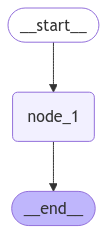

In [53]:
# Visualize the new graph
print(graph.get_graph())  # Print the graph structure
display(Image(graph.get_graph().draw_mermaid_png()))  # Render and display the graph

In [54]:
# Test the LLM-based graph with a motivational prompt
result = graph.invoke(FirstLLMAgentCall({"prompt": "Motivate me to learn LangGraph"}))
print(result)  # Print the final output

---Node 1 State--- {'prompt': 'Motivate me to learn LangGraph'}
{'prompt': 'Motivate me to learn LangGraph', 'output': 'Let\'s talk about why you should learn LangGraph.  Forget the jargon for a moment and focus on the *impact* you can have.\n\n**Imagine this:**\n\n* **You\'re a data scientist:**  You\'re drowning in unstructured text data – customer reviews, social media posts, research papers.  LangGraph gives you the power to untangle that mess, revealing hidden relationships and insights that traditional methods miss.  Imagine extracting actionable intelligence from that data, far faster and more accurately than ever before.  You become the hero who unlocks the hidden value in the data deluge.\n\n* **You\'re a software engineer:** You\'re building the next generation of AI-powered applications.  LangGraph provides a powerful toolkit for building sophisticated natural language processing (NLP) systems.  Imagine creating applications that understand context, nuance, and relationships